<a href="https://colab.research.google.com/github/noooobie/Ask-me-anything-app/blob/main/Project_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf


In [ ]:
device_list = tf.test.gpu_device_name()

In [ ]:
device_list

'/device:GPU:0'

In [ ]:
if device_list != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at :{}'.format(device_list))

Found GPU at :/device:GPU:0


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! pip install kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d draaslan/blood-cell-detection-dataset

 74% 9.00M/12.1M [00:00<00:00, 17.7MB/s]
100% 12.1M/12.1M [00:00<00:00, 24.5MB/s]


In [ ]:
!unzip /content/blood-cell-detection-dataset.zip

Archive:  /content/blood-cell-detection-dataset.zip
  inflating: .gitignore              
  inflating: LICENSE                 
  inflating: README.md               
  inflating: annotations.csv         
  inflating: images/image-1.png      
  inflating: images/image-10.png     
  inflating: images/image-100.png    
  inflating: images/image-101.png    
  inflating: images/image-102.png    
  inflating: images/image-103.png    
  inflating: images/image-104.png    
  inflating: images/image-105.png    
  inflating: images/image-106.png    
  inflating: images/image-107.png    
  inflating: images/image-108.png    
  inflating: images/image-109.png    
  inflating: images/image-11.png     
  inflating: images/image-110.png    
  inflating: images/image-111.png    
  inflating: images/image-112.png    
  inflating: images/image-113.png    
  inflating: images/image-114.png    
  inflating: images/image-115.png    
  inflating: images/image-116.png    
  inflating: images/image-117.png   

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
annotation = pd.read_csv("/content/annotations.csv")
annotation.head()

,image,xmin,ymin,xmax,ymax,label
0,image-100.png,0.000000,0.000000,25.190198,40.816803,rbc
1,image-100.png,15.010502,0.000000,68.337223,23.527421,rbc
2,image-100.png,25.017503,16.021004,78.374562,73.735123,rbc
3,image-100.png,75.565928,1.061844,140.248541,45.591599,rbc
4,image-100.png,77.483081,23.290548,131.936989,74.806301,rbc


In [ ]:
images = annotation.image.unique()

In [ ]:
train_images = images[:70]
test_images = images[70:]

In [ ]:
import os

In [ ]:
yolo_train_dir = "/kaggle/working/yolo/train"
yolo_test_dir = "/kaggle/working/yolo/test"

for dd in [yolo_train_dir, yolo_test_dir]:
    for ss in ["images", "labels"]:
        print(os.path.join(dd, ss))
        os.makedirs(os.path.join(dd, ss), exist_ok=True)

/kaggle/working/yolo/train/images
/kaggle/working/yolo/train/labels
/kaggle/working/yolo/test/images
/kaggle/working/yolo/test/labels


In [ ]:
import glob
from tqdm import tqdm
import os
import cv2
import matplotlib.pyplot as plt

(256, 256, 3)


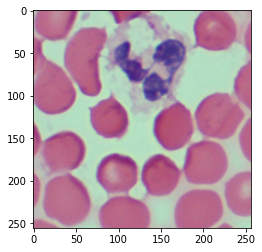

In [ ]:
image = cv2.imread('/content/images/image-1.png')
image = image[:,:,2::-1]
print(image.shape)
plt.imshow(image)

In [ ]:
WIDTH = 256
HEIGHT = 256
cells_id = {
    'rbc': 0,
    'wbc': 1
}

In [ ]:
cells_classes = list(cells_id.keys())
cells_classes

['rbc', 'wbc']

In [ ]:
for image in train_images:
    lables_file = os.path.join(yolo_train_dir, 'labels', image.replace(".png", ".txt"))
    with open(lables_file, "w") as wobj:
        for box in annotation.loc[annotation.image == image].values:
            wobj.write("%d %f %f %f %f \n" % (
                cells_id[box[5]],
                ((box[3]+box[1])/2.0) / WIDTH,
                ((box[4]+box[2])/2.0) / HEIGHT,
                (box[3]-box[1]) / WIDTH,
                (box[4]-box[2]) / HEIGHT
            ))
        
for image in test_images:
    lables_file = os.path.join(yolo_test_dir, 'labels', image.replace(".png", ".txt"))
    with open(lables_file, "w") as wobj:
        for box in annotation.loc[annotation.image == image].values:
            wobj.write("%d %f %f %f %f \n" % (
                cells_id[box[5]],
                ((box[3]+box[1])/2.0) / WIDTH,
                ((box[4]+box[2])/2.0) / HEIGHT,
                (box[3]-box[1]) / WIDTH,
                (box[4]-box[2]) / HEIGHT
            ))

In [ ]:
SIZE_W = 640
SIZE_H = 640

In [ ]:
SIZE = (SIZE_W, SIZE_H)

def replace_image(src_file, dst_file, size=SIZE):
    image = cv2.imread(src_file) 
    image = cv2.resize(image, size)
    cv2.imwrite(dst_file, image)

In [ ]:
train_images_dir = "/content/images"

for image in train_images:
    src_file = os.path.join(train_images_dir , image)
    dst_file = os.path.join(yolo_train_dir, 'images', image)
    replace_image(src_file, dst_file)
        
for image in test_images:
    src_file = os.path.join(train_images_dir , image)
    dst_file = os.path.join(yolo_test_dir, 'images', image)
    replace_image(src_file, dst_file)

/kaggle/working/yolo/train/images/image-100.png
/kaggle/working/yolo/train/labels/image-100.txt


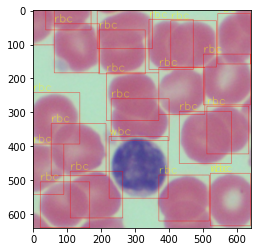

In [ ]:
def draw_image(image_file, label_file, class_names):   
    image = cv2.imread(image_file)
        
    with open(label_file) as fobj:
        while True:            
            item = fobj.readline()
            if item is None or len(item)<=0:
                break
                
            item = item.split()
            
            lb = int(item[0])
            xc = float(item[1]) * SIZE_W
            yc = float(item[2]) * SIZE_H
            w = float(item[3]) * SIZE_W
            h = float(item[4]) * SIZE_H
        
            image = cv2.rectangle(image, (int(xc - w/2), int(yc - h/2)), (int(xc + w/2), int(yc + h/2)), (0,0,255), 1)
            image = cv2.putText(image, class_names[lb], (int(xc - w/2), int(yc - h/2 - 5)), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 255, 255), 1)
        
    return image

train_file = train_images[0]
image_file = os.path.join(yolo_train_dir, 'images', train_file)
label_file = os.path.join(yolo_train_dir, 'labels', train_file.replace(".png", ".txt"))

print(image_file)
print(label_file)

image = draw_image(image_file, label_file, cells_classes)
image = image[:,:,2::-1]
plt.imshow(image);

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt
%cd -

Cloning into 'yolov5'...
remote: Enumerating objects: 12408, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 12408 (delta 1), reused 6 (delta 1), pack-reused 12401
Receiving objects: 100% (12408/12408), 11.52 MiB | 23.54 MiB/s, done.
Resolving deltas: 100% (8635/8635), done.
/content/yolov5
     |████████████████████████████████| 596 kB 12.6 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
/content


In [ ]:
!cat /content/yolov5/data/coco.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
# COCO 2017 dataset http://cocodataset.org by Microsoft
# Example usage: python train.py --data coco.yaml
# parent
# ├── yolov5
# └── datasets
#     └── coco  ← downloads here


# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../datasets/coco  # dataset root dir
train: train2017.txt  # train images (relative to 'path') 118287 images
val: val2017.txt  # val images (relative to 'path') 5000 images
test: test-dev2017.txt  # 20288 of 40670 images, submit to https://competitions.codalab.org/competitions/20794

# Classes
nc: 80  # number of classes
names: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'fris

In [ ]:
yaml_file="/content/yolov5/data/blood_cell.yaml"
train_images_dir = os.path.join("..", yolo_train_dir, "images")
val_images_dir = os.path.join("..", yolo_test_dir, "images")


names_str=""
for item in cells_classes:
    names_str=names_str + ", \'%s\'"%item
names_str= "names: ["+names_str[1:]+"]"

with open(yaml_file, "w") as wobj:
    wobj.write("train: %s\n"%train_images_dir)
    wobj.write("val: %s\n"%val_images_dir)
    wobj.write("nc: %d\n"%len(cells_classes))
    wobj.write(names_str+"\n")

In [ ]:
pip install wandb


     |████████████████████████████████| 1.7 MB 12.3 MB/s 
     |████████████████████████████████| 181 kB 45.9 MB/s 
     |████████████████████████████████| 144 kB 37.2 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=3293f978e09f0f37e89e390a522ae4974e9f7665985676ce1bcffe795b5b0cba
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
%cd yolov5
!bash weights/download_weights.sh

/content/yolov5
bash: weights/download_weights.sh: No such file or directory


/content/yolov5/data/scripts/download_weights.sh

In [ ]:
!mv *.pt weights
!ls weights

mv: cannot stat '*.pt': No such file or directory
ls: cannot access 'weights': No such file or directory


In [ ]:
!python train.py --data /content/yolov5/data/blood_cell.yaml --batch-size 4 --epochs 300 --img-size 640 --project /runs/train --name blood_cell --weights /content/yolov5/weights/yolov5s.pt --device 0

wandb: Currently logged in as: abinv (use `wandb login --relogin` to force relogin)
train: weights=/content/yolov5/weights/yolov5s.pt, cfg=, data=/content/yolov5/data/blood_cell.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=4, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/runs/train, name=blood_cell, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-85-g6f4eb95 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cl

In [ ]:
!python detect.py --weights /runs/train/blood_cell2/weights/best.pt --source /content/images/image-1.png --name blood_cell --project /runs/detect

detect: weights=['/runs/train/blood_cell2/weights/best.pt'], source=/content/images/image-1.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/runs/detect, name=blood_cell, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-85-g6f4eb95 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/images/image-1.png: 640x640 23 rbcs, 1 wbc, Done. (0.034s)
Speed: 0.7ms pre-process, 33.8ms inference, 3.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to /runs/detect/blood_cell


In [ ]:
!mkdir -p tmp
!cp /runs/train/blood_cell2/val_batch0_labels.jpg tmp/0.jpg
!cp /runs/train/blood_cell2/val_batch0_pred.jpg tmp/1.jpg
!ffmpeg -r 1 -i tmp/%d.jpg -r 1 -y tmp/out.gif

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
!ls -l /runs/detect/blood_cell

total 72
-rw-r--r-- 1 root root 71305 Apr  3 07:37 image-1.png


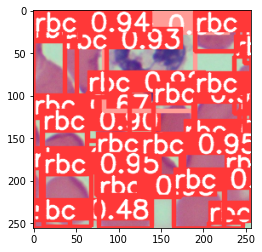

In [ ]:
img = cv2.imread("/runs/detect/blood_cell/image-1.png")
plt.imshow(img[:,:,2::-1]);

In [55]:
import torch

model = torch.hub.load('/content/yolov5', 'custom', path='/runs/train/blood_cell2/weights/best.pt', source='local')
# Images
imgs = ['/testimg/c0362224-800px-wm.jpg']  # batch of images

# Inference
results = model(imgs)

# Results
results.print()
results.save()  # or .show()

results.xyxy[0]  # img1 predictions (tensor)
results.pandas().xyxy[0] 

requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.1-85-g6f4eb95 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
image 1/1: 600x800 27 rbcs, 4 wbcs
Speed: 12.6ms pre-process, 30.6ms inference, 2.1ms NMS per image at shape (1, 3, 480, 640)
Saved 1 image to runs/detect/exp8


,xmin,ymin,xmax,ymax,confidence,class,name
0,560.690674,289.116638,649.891724,381.803314,0.970216,0,rbc
1,397.254395,350.346008,476.953491,439.010162,0.962487,0,rbc
2,174.000000,500.097107,257.547791,586.367493,0.961120,0,rbc
3,125.680000,184.892502,202.468719,263.899231,0.958200,0,rbc
4,374.132751,74.209297,454.316101,146.368195,0.952679,0,rbc
5,385.365234,507.465942,463.446594,593.013489,0.941914,0,rbc
6,413.791199,256.401672,493.773346,338.989532,0.941605,0,rbc
7,110.698692,246.233994,199.506042,320.787018,0.941290,0,rbc
8,719.279419,290.271881,799.514709,373.751801,0.940521,0,rbc
9,66.136009,487.120087,153.533340,567.712891,0.932674,0,rbc
